<a href="https://colab.research.google.com/github/25i6/semantic-segmentation/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 801, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 801 (delta 485), reused 756 (delta 474), pack-reused 3 (from 1)
Receiving objects: 100% (801/801), 54.99 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (485/485), done.
/content/semantic-segmentation
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=70bdbdee7ec1b8899731f6544a4627132741da7140fa7511e7fef7f8634efe80
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Cre

In [3]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [4]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [5]:
%pip install -U gdown

In [6]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=b5ab4792-787e-4a0c-8393-7b5316f9347b
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:04<00:00, 43.0MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [7]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

<ipython-input-7-288208e8de82>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map

Loaded Model


## Simple Image Inference

### Load Image

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


torch.Size([3, 583, 954])


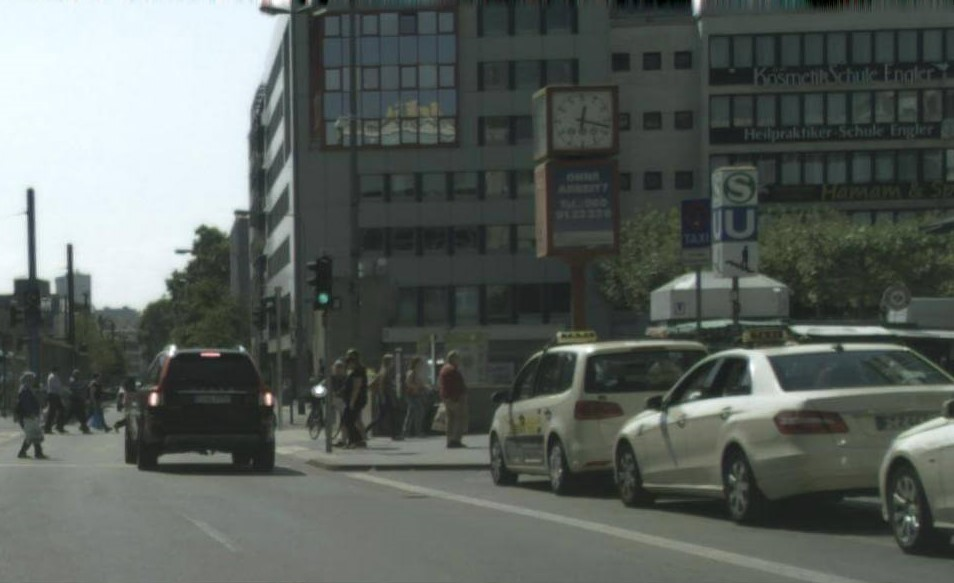

In [96]:
image_path = '/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/Segmentation.jpg'#最後がjpgとかじゃなくて日本語だと一個下のブロックでエラー
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [97]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [98]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [99]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([  1,   2,   4,   6,  11,  12,  20,  43,  87, 100, 102, 127, 136])

In [100]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

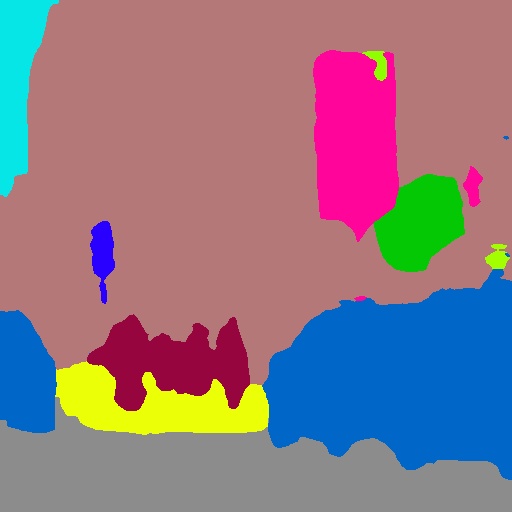

In [101]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

## Show Available Backbones

In [94]:
from semseg import show_backbones

show_backbones()

Backbone Names    Variants
----------------  ------------------------------------
ResNet            ['18', '34', '50', '101', '152']
ResNetD           ['18', '50', '101']
MicroNet          ['M1', 'M2', 'M3']
MobileNetV2       ['1.0']
MobileNetV3       ['S', 'L']
MiT               ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
PVTv2             ['B1', 'B2', 'B3', 'B4', 'B5']
ResT              ['S', 'B', 'L']
PoolFormer        ['S24', 'S36', 'M36']
ConvNeXt          ['T', 'S', 'B']


## Show Available Heads

In [32]:
from semseg import show_heads

show_heads()

  No.  Heads
-----  -------------
    1  UPerHead
    2  SegFormerHead
    3  SFHead
    4  FPNHead
    5  FaPNHead
    6  FCNHead
    7  CondHead
    8  LawinHead


## Show Available Datasets

In [33]:
from semseg import show_datasets

show_datasets()

  No.  Datasets
-----  ---------------
    1  CamVid
    2  CityScapes
    3  ADE20K
    4  MHPv1
    5  MHPv2
    6  LIP
    7  CIHP
    8  CCIHP
    9  ATR
   10  PASCALContext
   11  COCOStuff
   12  SUIM
   13  SunRGBD
   14  MapillaryVistas
   15  HELEN
   16  LaPa
   17  iBugMask
   18  CelebAMaskHQ
   19  FaceSynthetics


## Construct a Custom Model

### Choose a Backbone

In [34]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [35]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [20]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])
torch.Size([2, 256, 14, 14])
torch.Size([2, 512, 7, 7])


### Choose a Head

In [21]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [22]:
seg = head(features)
seg.shape

torch.Size([2, 10, 56, 56])

In [23]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

torch.Size([2, 10, 224, 224])

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.